#Libraries and Data

In [5]:
#import libraries
import numpy as np
import pandas as pd
import itertools
from prophet import Prophet
import yfinance
import pickle


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [6]:
#load the data

data = yfinance.download (tickers = "TATAPOWER.NS",start="2017-03-06",
                               interval = "1d", group_by = 'ticker', auto_adjust = True)

data.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2023-07-07,229.800003,232.350006,226.100006,228.000000,16592198
2023-07-10,229.250000,229.250000,224.649994,225.000000,7143637
2023-07-11,226.000000,226.850006,224.699997,225.500000,5156417
2023-07-12,226.250000,227.250000,225.199997,226.300003,7366992
2023-07-13,227.000000,227.199997,220.899994,221.699997,7703929


#Data preparation

In [8]:
#transform the date variable
data["Date"] = pd.to_datetime(data.index, format = "%m/%d/%Y")
data.Date

Date
2017-03-06   2017-03-06
2017-03-07   2017-03-07
2017-03-08   2017-03-08
2017-03-09   2017-03-09
2017-03-10   2017-03-10
                ...    
2023-07-07   2023-07-07
2023-07-10   2023-07-10
2023-07-11   2023-07-11
2023-07-12   2023-07-12
2023-07-13   2023-07-13
Name: Date, Length: 1572, dtype: datetime64[ns]

In [11]:
#renaming variables
data = data.rename(columns = {'Close': 'y',
                     'Date': 'ds'})
data.head(10)
data = data.reset_index()

#Holidays

In [5]:
#Easter
#easter_dates = df[df.Easter == 1].ds
#easter = pd.DataFrame({'holiday': 'easter',
#                      'ds': pd.to_datetime(easter_dates),
#                      'lower_window': -5,
#                      'upper_window': 2})
#easter.head(2)

In [6]:
#Thanksgiving
#thanksgiving_dates = df[df.Thanksgiving == 1].ds
#thanksgiving = pd.DataFrame({'holiday': 'thanksgiving',
 #                      'ds': pd.to_datetime(thanksgiving_dates),
  #                     'lower_window': -5,
   #                    'upper_window': 2})
#thanksgiving.head(2)

In [7]:
#combining holidays
#holidays = pd.concat([easter, thanksgiving])
#holidays

In [12]:
len(data)

1572

In [13]:
#create training and test set
test_days = 360
training_set = data.iloc[:-test_days,:]
test_set = data.iloc[-test_days:,:]

#Prophet

In [14]:
m = Prophet(
            #holidays = holidays,
            seasonality_mode = 'multiplicative',
            seasonality_prior_scale = 20,
            changepoint_prior_scale = 0.1,
           # holidays_prior_scale = 10
           )
#m.add_regressor('Christmas')
m.fit(training_set)

14:48:47 - cmdstanpy - INFO - Chain [1] start processing
14:48:49 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
#create future df
#future = m.make_future_dataframe(periods = test_days,
 #                                freq = "D")

In [21]:
future = pd.DataFrame({"ds" : data.ds})

In [22]:
#forecast
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
1567,2023-07-07,346.600807,201.957080,522.290611,195.583582,504.689408,0.032516,0.032516,0.032516,0.174138,0.174138,0.174138,-0.141622,-0.141622,-0.141622,0.0,0.0,0.0,357.870893
1568,2023-07-10,347.550450,201.664705,520.092836,195.999495,506.377177,0.026253,0.026253,0.026253,0.174275,0.174275,0.174275,-0.148022,-0.148022,-0.148022,0.0,0.0,0.0,356.674781
1569,2023-07-11,347.866997,203.906079,521.765915,196.084631,507.431850,0.026059,0.026059,0.026059,0.175662,0.175662,0.175662,-0.149603,-0.149603,-0.149603,0.0,0.0,0.0,356.932173
1570,2023-07-12,348.183545,203.318499,529.108659,196.303977,508.486523,0.032441,0.032441,0.032441,0.183313,0.183313,0.183313,-0.150872,-0.150872,-0.150872,0.0,0.0,0.0,359.478897
1571,2023-07-13,348.500092,199.182874,522.680080,196.164595,509.311338,0.029740,0.029740,0.029740,0.181561,0.181561,0.181561,-0.151821,-0.151821,-0.151821,0.0,0.0,0.0,358.864548


In [31]:
data = data.reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill='')
data = data.drop("index",axis=1)

In [32]:
#get some variables
prophet_variables = forecast.loc[:, ["trend", "weekly",  "multiplicative_terms"]]
df_xgb = pd.concat([data, prophet_variables], axis = 1)
df_xgb.head(1)

,level_0,Date,Open,High,Low,y,Volume,Data,ds,trend,weekly,multiplicative_terms
0,0,2017-03-06,68.984702,69.615659,68.900575,69.363274,4706563,2017-03-06,2017-03-06,61.530728,0.174275,0.222305


In [33]:
print(len(df_xgb))

1572


#XGBoost preparation

In [34]:
#create training and test set
test_days = 360
training_set = df_xgb.iloc[:-test_days,:]
test_set = df_xgb.iloc[-test_days:,:]

In [35]:
#isolate X and y
y_train = training_set.y
y_test = test_set.y 
X_train = training_set.iloc[:, 2:]
X_test = test_set.iloc[:, 2:]

In [37]:
y_test

1212    241.844009
1213    245.579056
1214    246.316223
1215    248.527771
1216    250.002136
           ...    
1567    228.000000
1568    225.000000
1569    225.500000
1570    226.300003
1571    221.699997
Name: y, Length: 360, dtype: float64

In [45]:
X_train = X_train.drop(columns=["ds","Data"])
X_test = X_test.drop(columns=["ds","Data"])


In [46]:
#Matrices
import xgboost as xgb
Train = xgb.DMatrix(X_train, label = y_train)
Test = xgb.DMatrix(X_test, label = y_test)

In [47]:
#set the parameters
parameters = {'learning_rate': 0.3,
              'max_depth': 6,
              'colsample_bytree': 1,
              'subsample': 1,
              'min_child_weight' : 1,
              'gamma': 0,
              'random_state': 1502,
              'eval_metric': "rmse",
              'objective': "reg:squarederror"}

#XGBoost

In [48]:
model = xgb.train(params = parameters,
                  dtrain = Train,
                  num_boost_round = 40,
                  evals = [(Test, "y")])

[0]	y-rmse:154.35560
[1]	y-rmse:108.18962
[2]	y-rmse:75.30271
[3]	y-rmse:54.27492
[4]	y-rmse:39.50353
[5]	y-rmse:28.37901
[6]	y-rmse:20.88447
[7]	y-rmse:15.68478
[8]	y-rmse:12.10307
[9]	y-rmse:9.67400
[10]	y-rmse:8.29856
[11]	y-rmse:7.35159
[12]	y-rmse:6.53390
[13]	y-rmse:6.02334
[14]	y-rmse:5.66943
[15]	y-rmse:5.49496
[16]	y-rmse:5.28548
[17]	y-rmse:5.20180
[18]	y-rmse:5.11619
[19]	y-rmse:5.04858
[20]	y-rmse:5.05666
[21]	y-rmse:5.03507
[22]	y-rmse:5.01235
[23]	y-rmse:4.99737
[24]	y-rmse:4.94646
[25]	y-rmse:4.93269
[26]	y-rmse:4.92654
[27]	y-rmse:4.93509
[28]	y-rmse:4.92914
[29]	y-rmse:4.92251
[30]	y-rmse:4.94226
[31]	y-rmse:4.94148
[32]	y-rmse:4.93124
[33]	y-rmse:4.93176
[34]	y-rmse:4.93381
[35]	y-rmse:4.93821
[36]	y-rmse:4.93726
[37]	y-rmse:4.93550
[38]	y-rmse:4.93577
[39]	y-rmse:4.93581


In [49]:
model_path = 'prophet_model.pkl'
# Save the model to the specified path
with open(model_path, 'wb') as f:
    print(f)
    pickle.dump(model, f)

<_io.BufferedWriter name='prophet_model.pkl'>


In [41]:
with open('prophet_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
    print(loaded_model)


In [37]:
#f_predictions = pd.Series(model.predict(Future), name = "XGBoost")
#f_predictions


['/bin/bash: -c: line 1: syntax error: unexpected end of file']


In [50]:
#forecasting
predictions = pd.Series(model.predict(Test), name = "XGBoost")
predictions.index  =test_set.ds

#VIZ and assessment

In [51]:
#Visualization
training_set.index = training_set.ds
test_set.index = test_set.ds

<Axes: xlabel='ds'>

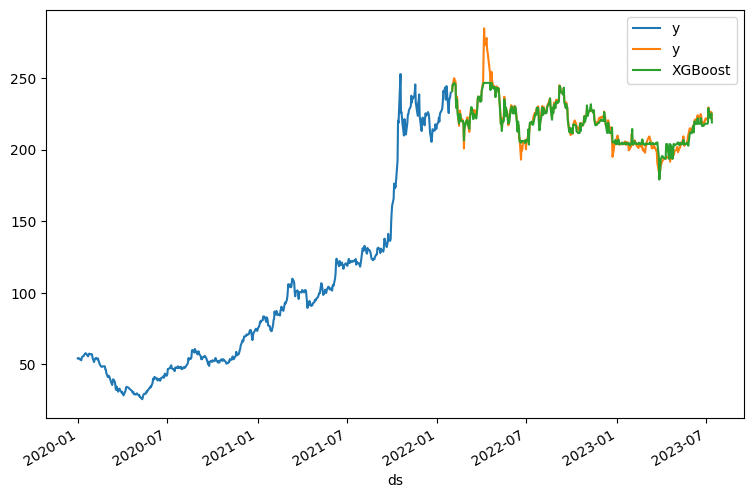

In [52]:
training_set.y['2020-01-01':].plot(figsize = (9,6), legend = True)
test_set.y.plot(legend = True)
predictions.plot(legend = True)

In [27]:
#MAPE
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set.y, predictions)

0.8678856943128023

#Future



In [28]:
# Create a dictionary with data
data = {
            'High': [4.123123],
    'Low': [4.123123],
    'y': [210.935516],
    'Volume': [4.123123],
        'trend': [8.12313],
        'weekly': [4.123123],
            'multiplicative_terms': [4.444],
                

                
                }

# Create a new DataFrame object
df = pd.DataFrame(data)


In [29]:
Future = xgb.DMatrix(df, label = df.y)
f_predictions = pd.Series(model.predict(Future), name = "XGBoost")
f_predictions

0    153.933731
Name: XGBoost, dtype: float32